### Day by day trading - 2019-01-16

In [1]:
# Import standard libraries
%matplotlib inline

import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pylab as plt
from pandas.tseries.offsets import BDay
import os
import os.path
import pickle
import random
import json
from scipy import stats
from datetime import datetime

from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Import custom libraries
from Code.lib.plot_utils import PlotUtility
from Code.lib.time_utils import TimeUtility
from Code.lib.retrieve_data import DataRetrieve, ComputeTarget
from Code.lib.candle_indicators import CandleIndicators
from Code.lib.transformers import Transformers
from Code.lib.ta_momentum_studies import TALibMomentumStudies
from Code.lib.model_utils import ModelUtility, TimeSeriesSplitImproved
from Code.lib.feature_generator import FeatureGenerator
from Code.utilities.stat_tests import stationarity_tests
from Code.lib.config import current_feature, feature_dict
from Code.models import models_utils
from Code.lib.model_algos import AlgoUtility

plotIt = PlotUtility()
timeUtil = TimeUtility()
ct = ComputeTarget()
candle_ind = CandleIndicators()
dSet = DataRetrieve()
taLibMomSt = TALibMomentumStudies()
transf = Transformers()
modelUtil = ModelUtility()
featureGen = FeatureGenerator()
dSet = DataRetrieve()
modelAlgo = AlgoUtility()

In [3]:
# function to create system directory based on system name if one doesn't already exist
def get_system_dir(system_name):
    # Create system directory in current path
    current_directory = os.getcwd()
    system_directory = os.path.join(current_directory, system_name)
    if not os.path.exists(system_directory):
       os.makedirs(system_directory)
    return system_directory

In [4]:
# functions for save and load json files
def save_json(filename, json_file):
    # Save system_dict to file
    #filename = 'system_dict.json'
    file_path = os.path.join(system_directory, filename)
    with open(file_path, 'w') as fp:
        json.dump(json_file, fp, sort_keys=True, indent=4)
        
def load_json(file_path):
    with open(file_path, 'r') as fp:
        json_file = json.load(fp)
    return json_file

### Get system info

In [5]:
system_name = "TLT-Long-system-7045-V1"

In [6]:
# Get system info
current_directory = os.getcwd()
system_directory = os.path.join(current_directory, system_name)
if not os.path.exists(system_directory):
    print("system doesn't exist")
else:
    filename = 'system_dict.json'    
    file_path = os.path.join(system_directory, filename)
    system_dict = load_json(file_path)
    issue = system_dict["issue"]
    direction = system_dict["direction"]
    ver_num = system_dict["ver_num"]
    # Perhaps only load these when needed?
    pivotDate = system_dict["pivot_date"]
    is_oos_ratio = system_dict["is_oos_ratio"]
    oos_months = system_dict["oos_months"]
    segments = system_dict["segments"]

In [7]:
# Set IS-OOS parameters
from datetime import datetime
pivotDate = datetime.strptime(pivotDate, '%Y-%m-%d')
print(pivotDate)
pivotDate = datetime.date(pivotDate)

# set date splits
isOosDates = timeUtil.is_oos_data_split(issue, pivotDate, is_oos_ratio, oos_months, segments)
dataLoadStartDate = isOosDates[0]
is_start_date = isOosDates[1]
oos_start_date = isOosDates[2]
is_months = isOosDates[3]
is_end_date = isOosDates[4]
oos_end_date = isOosDates[5]

modelStartDate = oos_start_date

2019-01-15 00:00:00
                    Segments:  1
                IS OOS Ratio:  4
                  OOS months:  4
                   IS Months:  16
              Months to load:  20
              Data Load Date:  2017-04-15
              IS Start  Date:  2017-05-15
              OOS Start Date:  2018-09-15
                  Pivot Date:  2019-01-15


### Set trade date
In this case, increment to next business day after pivotDate

Do it manually for now

In [8]:
from datetime import timedelta
from pandas.tseries.offsets import BDay
tradeDate = pivotDate + BDay(1)
print(tradeDate)

2019-01-16 00:00:00


### Retrieve feature_dict

In [9]:
file_name = 'feature_dict.json'
file_path = os.path.join(system_directory, file_name)
feature_dict = load_json(file_path)

### Day by day procedure
1. Set trade date
2. Update close, transform
3. Retrieve model
4. Make prediction
5. Update prev day gainAhead, trade (using TRADE DECISION), Equity (what df?)
6. Update shadow trades df from (5)
7. Calculate safe-f, CAR25 (TMS-Part 1)
8. TRADE DECISION
9. Update pivot date in dict

### Steps to walkthrough
1. Make copy of raw data and truncate it to pretend existing date

In [10]:
raw_df = dSet.read_issue_data(issue)

Successfully retrieved data series for TLT


In [11]:
raw_df.tail(35)

,Date,Open,High,Low,Close,AdjClose,Volume
4133,2018-12-26,120.99,121.3900,119.9700,120.0200,119.7479,11700412.0
4134,2018-12-27,121.26,121.3800,119.9800,120.0400,119.7679,12146772.0
4135,2018-12-28,120.40,121.0500,120.2900,121.0500,120.7756,9879116.0
4136,2018-12-31,120.65,121.5600,120.4600,121.5100,121.2345,17408971.0
4137,2019-01-02,121.66,122.1600,121.3401,122.1500,121.8731,19841527.0
4138,2019-01-03,122.29,123.8600,122.2267,123.5400,123.2599,21187045.0
4139,2019-01-04,122.34,122.5600,121.6500,122.1100,121.8332,12970226.0
4140,2019-01-07,122.62,122.6500,121.6200,121.7500,121.4740,8498104.0
4141,2019-01-08,121.69,121.9400,121.3900,121.4300,121.1547,7737103.0
4142,2019-01-09,121.26,121.4300,120.7950,121.2400,120.9651,9349245.0


#### Trim df to 2019-01-09, then add 2019-01-10
Don't use set_date_range to update to new date data

In [12]:
tradeDate = tradeDate.strftime('%Y-%m-%d')
tradeDate

'2019-01-16'

In [13]:
# Use trade date instead of hard coding date
trimmed_df = raw_df.iloc[0:raw_df[raw_df.Date == tradeDate].index[0]]
trimmed_df.tail(2)

,Date,Open,High,Low,Close,AdjClose,Volume
4145,2019-01-14,120.90,121.01,120.2416,120.48,120.2069,6730681.0
4146,2019-01-15,120.56,120.57,119.9500,120.04,119.7679,8997352.0


In [14]:
price_loc = raw_df.index[raw_df.Date == tradeDate]
index = price_loc[0]
index

4147

In [15]:
new_open = raw_df.Close[index]
new_open

120.16

In [16]:
# add 2019-01-08
new_data_df = trimmed_df.append({'Date' : tradeDate , 'Open' : raw_df.Open[index], 'High' : raw_df.High[index], 'Low' : raw_df.Low[index], 'Close' : raw_df.Close[index], 'AdjClose' : raw_df.AdjClose[index], 'Volume' : raw_df.Volume[index] } , ignore_index=True)
new_data_df.tail(2)

,Date,Open,High,Low,Close,AdjClose,Volume
4146,2019-01-15,120.56,120.57,119.95,120.04,119.7679,8997352.0
4147,2019-01-16,119.59,120.39,119.51,120.16,119.8876,6048446.0


In [17]:
# get first row
df_start_date = new_data_df.Date[0]
df_start_date

'2002-07-26'

In [18]:
# get last row
lastRow = new_data_df.shape[0]
df_end_date = new_data_df.Date[lastRow-1]
df_end_date

'2019-01-16'

In [19]:
feat_df = dSet.set_date_range(new_data_df, df_start_date, df_end_date)
# Resolve any NA's for now
feat_df.fillna(method='ffill', inplace=True)

#set beLong level
beLongThreshold = 0.000
feat_df = ct.setTarget(new_data_df, "Long", beLongThreshold)

In [20]:
feat_df.tail(2)

,Open,High,Low,Close,AdjClose,Volume,gainAhead,beLong
Date,,,,,,,,
2019-01-15,120.56,120.57,119.95,120.04,119.7679,8997352.0,0.001,1
2019-01-16,119.59,120.39,119.51,120.16,119.8876,6048446.0,0.000,-1


#### Adding features with new day
Should I be generating new features again?
How would add just one day's worth?

In [21]:
file_name = 'input_dict.json'
file_path = os.path.join(system_directory, file_name)
input_dict = load_json(file_path)

In [22]:
feat_df = featureGen.generate_features(feat_df, input_dict)

f1
fname:  PPO
params:  [2, 5]
Current feature:  PPO_f2_s5
transform:  ['Normalized', 20]
pass params [20]
f10
fname:  kaufman_AMA
params:  [4]
Current feature:  KAMA_4
transform:  ['Normalized', 20]
pass params [20]
f2
fname:  RSI
params:  [2]
Current feature:  RSI_2
transform:  ['Normalized', 20]
pass params [20]
f3
fname:  CMO
params:  [5]
Current feature:  CMO_5
transform:  ['Normalized', 20]
pass params [20]
f4
fname:  CCI
params:  [10]
Current feature:  CCI_10
transform:  ['Normalized', 20]
pass params [20]
f5
fname:  UltimateOscillator
params:  [10, 20, 30]
Current feature:  UltOsc_t110_t220_t330
transform:  ['Normalized', 20]
pass params [20]
f6
fname:  ROC
params:  [10]
Current feature:  ROC_10
transform:  ['Normalized', 20]
pass params [20]
f7
fname:  Lag
params:  ['Close', 3]
Date
2018-12-18    120.72
2018-12-19    121.32
2018-12-20    120.02
2018-12-21    120.04
2018-12-24    121.05
2018-12-26    121.51
2018-12-27    122.15
2018-12-28    123.54
2018-12-31    122.11
2019-01-

f8
fname:  Lag
params:  ['Close', 5]
Date
2018-12-18    120.02
2018-12-19    120.04
2018-12-20    121.05
2018-12-21    121.51
2018-12-24    122.15
2018-12-26    123.54
2018-12-27    122.11
2018-12-28    121.75
2018-12-31    121.43
2019-01-02    121.24
2019-01-03    120.46
2019-01-04    120.93
2019-01-07    120.48
2019-01-08    120.04
2019-01-09    120.16
2019-01-10       NaN
2019-01-11       NaN
2019-01-14       NaN
2019-01-15       NaN
2019-01-16       NaN
Name: Close_lag5, dtype: float64
              Open     High       Low   Close  AdjClose      Volume  \
Date                                                                  
2018-12-18  119.07  119.785  118.9400  119.60  119.3289  10019103.0   
2018-12-19  120.11  121.660  119.9200  121.18  120.9053  23046272.0   
2018-12-20  122.01  122.030  120.6700  120.74  120.4663  18543731.0   
2018-12-21  121.14  121.210  120.3900  120.72  120.4463   9945103.0   
2018-12-24  121.13  121.420  120.9100  121.32  121.0450   8377482.0   
2018-12-

f9
fname:  ChaikinADOSC
params:  [4, 10]
Current feature:  ChaikinADOSC_f4_s10
transform:  ['Normalized', 20]
pass params [20]


In [23]:
feat_df = transf.normalizer(feat_df, 'Volume', 50)

In [24]:
feat_df.tail(2)

,Open,High,Low,Close,AdjClose,Volume,gainAhead,beLong,PPO_f2_s5,PPO_f2_s5_Normalized,...,UltOsc_t110_t220_t330_Normalized,ROC_10,ROC_10_Normalized,Close_lag3,Close_lag3_Normalized,Close_lag5,Close_lag5_Normalized,ChaikinADOSC_f4_s10,ChaikinADOSC_f4_s10_Normalized,Volume_Normalized
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-15,120.56,120.57,119.95,120.04,119.7679,8997352.0,0.001,1,-0.306723,0.328564,...,0.094909,-1.209777,0.043383,120.10,0.197950,120.10,0.253266,-8.210966e+05,0.359227,0.567391
2019-01-16,119.59,120.39,119.51,120.16,119.8876,6048446.0,0.000,-1,-0.260767,0.357933,...,0.090831,-1.629144,0.034822,120.16,0.293099,120.16,0.330144,-1.276137e+06,0.334604,0.234294


In [25]:
col_vals = [k for k,v in feature_dict.items() if v == 'Drop']
to_drop = ['Open','High','Low', 'gainAhead', 'Close', 'Volume', 'AdjClose', 'beLong']
for x in to_drop:
    col_vals.append(x)
model_data = dSet.drop_columns(feat_df, col_vals)

In [26]:
model_data.tail(2)

,PPO_f2_s5_Normalized,RSI_2_Normalized,UltOsc_t110_t220_t330_Normalized,ROC_10_Normalized,Close_lag3_Normalized,Close_lag5_Normalized,ChaikinADOSC_f4_s10_Normalized,Volume_Normalized
Date,,,,,,,,
2019-01-15,0.328564,0.200454,0.094909,0.043383,0.197950,0.253266,0.359227,0.567391
2019-01-16,0.357933,0.336517,0.090831,0.034822,0.293099,0.330144,0.334604,0.234294


In [27]:
# Retrieve model
best_model_name = system_dict["best_model"]
file_title = "fit-model-" + best_model_name + "-IS-" + system_name + ".sav"
file_name = os.path.join(system_directory, file_title)
model = pickle.load(open(file_name, 'rb'))

In [28]:
# get last row of data
lastRow = model_data.shape[0]
model_end_date = model_data.index[lastRow-1]
print(model_end_date)

2019-01-16 00:00:00


In [29]:
# Make prediction
predict_data = model_data.iloc[lastRow-1]
dX = np.zeros_like(predict_data)
dX = predict_data.values
dX = dX.reshape(1, -1)
dX

array([[ 0.35793262,  0.33651659,  0.0908311 ,  0.03482226,  0.29309866,
         0.3301438 ,  0.33460361,  0.23429376]])

In [30]:
# get prediction
y_validate = []
y_validate = model.predict(dX)
y_validate

array([1])

In [31]:
y_validate[0]

1

In [32]:
# Get shadow trades
filename = "OOS_Equity_daybyday_" + system_name + ".csv"
path = system_directory+ "\\" + filename
shadow_trades = pd.read_csv(path)

In [33]:
shadow_trades.tail(2)

,Date,signal,gainAhead,Close
91,2019-01-14,1,-0.003652,120.48
92,2019-01-15,1,0.000000,120.04


In [34]:
model_data.tail(3)


,PPO_f2_s5_Normalized,RSI_2_Normalized,UltOsc_t110_t220_t330_Normalized,ROC_10_Normalized,Close_lag3_Normalized,Close_lag5_Normalized,ChaikinADOSC_f4_s10_Normalized,Volume_Normalized
Date,,,,,,,,
2019-01-14,0.393689,0.262660,0.290073,0.110594,0.236766,0.279082,0.503944,0.289471
2019-01-15,0.328564,0.200454,0.094909,0.043383,0.197950,0.253266,0.359227,0.567391
2019-01-16,0.357933,0.336517,0.090831,0.034822,0.293099,0.330144,0.334604,0.234294


In [35]:
feat_df.Close[lastRow-1]

120.16

#### Update shadow trades to start
- Current date, signal for date, Close for date, gainAhead for previous Day

In [36]:
new_st_df = shadow_trades.append({'Date' : tradeDate , 'signal' : y_validate[0], 'gainAhead' : 0.000, 'Close' : feat_df.Close[lastRow-1] } , ignore_index=True)

In [37]:
new_st_df.tail(3)

,Date,signal,gainAhead,Close
91,2019-01-14,1,-0.003652,120.48
92,2019-01-15,1,0.000000,120.04
93,2019-01-16,1,0.000000,120.16


In [38]:
new_st_df['gainAhead'] = ct.gainAhead(new_st_df.Close)

In [39]:
new_st_df.tail(3)

,Date,signal,gainAhead,Close
91,2019-01-14,1,-0.003652,120.48
92,2019-01-15,1,0.001000,120.04
93,2019-01-16,1,0.000000,120.16


#### Save updated shadow trades

In [40]:
#print(df_to_save)
filename = "OOS_Equity_daybyday_" + system_name + ".csv"
new_st_df.to_csv(system_directory+ "\\" + filename, encoding='utf-8', index=False)

#### Load TMS - Part 1

In [41]:
filename = "TMS_Part1_daybyday_" + system_name + ".csv"
path = system_directory+ "\\" + filename
tms1 = pd.read_csv(path)
tms1.tail(3)

,Date,signal,gainAhead,Close,safef,CAR25
90,2019-01-11,1,-0.003721,120.93,3.331022,91.507689
91,2019-01-14,1,-0.003652,120.48,3.223007,78.315826
92,2019-01-15,1,0.000000,120.04,3.327036,72.305941


In [42]:
# Update TMS-Part 1 data with latest date
sst = tms1.append({'Date' : tradeDate , 'signal' : y_validate[0], 'gainAhead' : 0, 'Close' :  feat_df.Close[lastRow-1]} , ignore_index=True)
sst.tail(3)

,Date,signal,gainAhead,Close,safef,CAR25
91,2019-01-14,1,-0.003652,120.48,3.223007,78.315826
92,2019-01-15,1,0.000000,120.04,3.327036,72.305941
93,2019-01-16,1,0.000000,120.16,NaN,NaN


In [43]:
# Update with gainAhead
end = sst.index[-2]
sst.iloc[end,sst.columns.get_loc('gainAhead')] = new_st_df.iloc[end,new_st_df.columns.get_loc('gainAhead')]
sst.tail(3)

,Date,signal,gainAhead,Close,safef,CAR25
91,2019-01-14,1,-0.003652,120.48,3.223007,78.315826
92,2019-01-15,1,0.001000,120.04,3.327036,72.305941
93,2019-01-16,1,0.000000,120.16,NaN,NaN


#### Update TMS-Part 1 with safe-f, CAR25

In [44]:
nrows = sst.shape[0]
# sst = sst.set_index(pd.DatetimeIndex(sst['Date']))
start = sst.index[0]
end = sst.index[-1]

iStart = sst.index.get_loc(end)-1
iEnd = sst.index.get_loc(end)

In [45]:
# retrieve tms_dict
file_name = 'tms_dict.json'
file_path = os.path.join(system_directory, file_name)
tms_dict = load_json(file_path)

forecastHorizon = tms_dict["forecastHorizon"]
initialEquity = tms_dict["initialEquity"]
ddTolerance = tms_dict["ddTolerance"]
tailRiskPct = tms_dict["tailRiskPct"]
windowLength = tms_dict["windowLength"]
nCurves = tms_dict["nCurves"]
updateInterval = tms_dict["updateInterval"]

years_in_forecast = forecastHorizon / 252.0

printDetails = False

In [46]:
# Calculate safe-f, CAR25
for i in range(iStart, iEnd+1, updateInterval):
    if printDetails: 
        print ("\nDate: ", dt.datetime.strftime(sst.index[i], '%Y-%m-%d'))
        print ("beLong: ", sst.signal[i])
        print ("gain Ahead: {0:.4f}".format(sst.gainAhead[i]))

#  Initialize variables
    curves = np.zeros(nCurves)
    numberDraws = np.zeros(nCurves)
    TWR = np.zeros(nCurves)
    maxDD = np.zeros(nCurves)
    
    fraction = 1.00
    dd95 = 2 * ddTolerance
    
    while (abs(dd95-ddTolerance)>0.03):
        #  Generate nCurve equity curves
        if printDetails: 
            print  ("    Fraction {0:.2f}".format(fraction))
#    
        for nc in range(nCurves):
            #print ("working on curve ", nc)
            equity = initialEquity
            maxEquity = equity
            drawdown = 0
            maxDrawdown = 0
            horizonSoFar = 0
            nd = 0
            while (horizonSoFar < forecastHorizon):
                j = np.random.randint(0,windowLength)
        #        print j
                nd = nd + 1
                weightJ = 1.00 - j/windowLength
        #        print weightJ
                horizonSoFar = horizonSoFar + weightJ
                signalJ = sst.signal[i-j]
                if signalJ > 0:
                    tradeJ = sst.gainAhead[i-j] * weightJ
                else:
                    tradeJ = 0.0
                thisTrade = fraction * tradeJ * equity    
                equity = equity + thisTrade
                maxEquity = max(equity,maxEquity)
                drawdown = (maxEquity-equity)/maxEquity
                maxDrawdown = max(drawdown,maxDrawdown)
    #        print "equity, maxDD, ndraws:", equity, maxDrawdown, nd        
            TWR[nc] = equity
            maxDD[nc] = maxDrawdown
            numberDraws[nc] = nd
    
        #  Find the drawdown at the tailLimit-th percentile        
        dd95 = stats.scoreatpercentile(maxDD,tailRiskPct)
        if printDetails: 
            print ('  DD {0}: {1:.3f} '.format(tailRiskPct, dd95))
        fraction = fraction * ddTolerance / dd95
        TWR25 = stats.scoreatpercentile(TWR,25)        
        CAR25 = 100*(((TWR25/initialEquity) ** (1.0/years_in_forecast))-1.0)
    if printDetails: 
        print ('Fraction: {0:.2f}'.format(fraction))
        print ('CAR25: {0:.2f}'.format(CAR25))
    sst.iloc[i,sst.columns.get_loc('safef')] = fraction
    sst.iloc[i,sst.columns.get_loc('CAR25')] = CAR25
    #sst.loc[i,'CAR25'] = CAR25

In [47]:
sst.tail(5)

,Date,signal,gainAhead,Close,safef,CAR25
89,2019-01-10,1,0.003902,120.46,3.647966,127.248937
90,2019-01-11,1,-0.003721,120.93,3.331022,91.507689
91,2019-01-14,1,-0.003652,120.48,3.223007,78.315826
92,2019-01-15,1,0.001000,120.04,3.374036,81.167388
93,2019-01-16,1,0.000000,120.16,3.421082,83.712713


#### Save updated shadow trades

In [48]:
df_to_save = sst.copy()
#df_to_save.reset_index(level=df_to_save.index.names, inplace=True)
filename = "TMS_Part1_daybyday_" + system_name + ".csv"
df_to_save.to_csv(system_directory+ "\\" + filename, encoding='utf-8', index=False)

In [49]:
df_to_save.tail(3)

,Date,signal,gainAhead,Close,safef,CAR25
91,2019-01-14,1,-0.003652,120.48,3.223007,78.315826
92,2019-01-15,1,0.001000,120.04,3.374036,81.167388
93,2019-01-16,1,0.000000,120.16,3.421082,83.712713


#### Now go to TMS Part 2

In [50]:
filename = "TMS_Part2_daybyday_" + system_name + ".csv"
path = system_directory+ "\\" + filename
tms2 = pd.read_csv(path)
tms2.tail(3)

,Date,signal,gainAhead,Close,safef,CAR25,trade,fract,equity,maxEquity,drawdown,maxDD,trade_decision
90,2019-01-11,1,-0.003721,120.93,3.719853,128.703587,-1850.826173,3.719853,141159.147779,150881.27067,0.064436,0.104042,Long
91,2019-01-14,1,-0.003652,120.48,3.390461,93.351819,-1917.663836,3.390461,139241.483943,150881.27067,0.077145,0.104042,Long
92,2019-01-15,1,0.000000,120.04,3.327036,72.305941,NaN,NaN,NaN,NaN,NaN,NaN,Long


#### Append last day  form TMS Part 1 to TMS Part 2

In [51]:
tms21 = tms2.copy()
sst1 = sst.copy()
#sst1.reset_index(level=sst1.index.names, inplace=True)
tms21.loc[sst1.index[-1]] = sst1.iloc[-1]

In [52]:
tms21.tail(3)

,Date,signal,gainAhead,Close,safef,CAR25,trade,fract,equity,maxEquity,drawdown,maxDD,trade_decision
91,2019-01-14,1,-0.003652,120.48,3.390461,93.351819,-1917.663836,3.390461,139241.483943,150881.27067,0.077145,0.104042,Long
92,2019-01-15,1,0.000000,120.04,3.327036,72.305941,NaN,NaN,NaN,NaN,NaN,NaN,Long
93,2019-01-16,1,0.000000,120.16,3.421082,83.712713,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
nrows = tms21.shape[0]
start = tms21.index[0]
end = tms21.index[-1]

iStart = tms21.index.get_loc(end)-1
iEnd = tms21.index.get_loc(end)

In [54]:
iStart

92

In [55]:
# Update gainAhead
tms21.iloc[iStart,tms21.columns.get_loc('gainAhead')] = sst1.iloc[iStart,sst1.columns.get_loc('gainAhead')]

In [56]:
tms21.tail(3)

,Date,signal,gainAhead,Close,safef,CAR25,trade,fract,equity,maxEquity,drawdown,maxDD,trade_decision
91,2019-01-14,1,-0.003652,120.48,3.390461,93.351819,-1917.663836,3.390461,139241.483943,150881.27067,0.077145,0.104042,Long
92,2019-01-15,1,0.001000,120.04,3.327036,72.305941,NaN,NaN,NaN,NaN,NaN,NaN,Long
93,2019-01-16,1,0.000000,120.16,3.421082,83.712713,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Update trade_decision with current date decision
tms21.iloc[iEnd,tms21.columns.get_loc('trade_decision')] = 'Long'

In [58]:
tms21.tail(3)

,Date,signal,gainAhead,Close,safef,CAR25,trade,fract,equity,maxEquity,drawdown,maxDD,trade_decision
91,2019-01-14,1,-0.003652,120.48,3.390461,93.351819,-1917.663836,3.390461,139241.483943,150881.27067,0.077145,0.104042,Long
92,2019-01-15,1,0.001000,120.04,3.327036,72.305941,NaN,NaN,NaN,NaN,NaN,NaN,Long
93,2019-01-16,1,0.000000,120.16,3.421082,83.712713,NaN,NaN,NaN,NaN,NaN,NaN,Long


In [59]:
for i in range(iStart, iEnd):
    if (tms21.trade_decision[i] == 'Long'):
        tms21.iloc[i,tms21.columns.get_loc('trade')] = tms21.iloc[i-1,tms21.columns.get_loc('fract')] * tms21.iloc[i-1,tms21.columns.get_loc('equity')] * tms21.iloc[i,tms21.columns.get_loc('gainAhead')]
    elif (tms21.signal[i] > 0):
        tms21.iloc[i,tms21.columns.get_loc('trade')] = tms21.iloc[i-1,tms21.columns.get_loc('fract')] * tms21.iloc[i-1,tms21.columns.get_loc('equity')] * tms21.iloc[i,tms21.columns.get_loc('gainAhead')]
    else:
        tms21.iloc[i,tms21.columns.get_loc('trade')] = 0.0
        
    tms21.iloc[i,tms21.columns.get_loc('fract')] = tms21.iloc[i,tms21.columns.get_loc('safef')]
    
    tms21.iloc[i,tms21.columns.get_loc('equity')] = tms21.iloc[i-1,tms21.columns.get_loc('equity')] + tms21.iloc[i,tms21.columns.get_loc('trade')]
    tms21.iloc[i,tms21.columns.get_loc('maxEquity')] = max(tms21.iloc[i,tms21.columns.get_loc('equity')],tms21.iloc[i-1,tms21.columns.get_loc('maxEquity')])
    tms21.iloc[i,tms21.columns.get_loc('drawdown')] = (tms21.iloc[i,tms21.columns.get_loc('maxEquity')] - tms21.iloc[i,tms21.columns.get_loc('equity')]) / tms21.iloc[i,tms21.columns.get_loc('maxEquity')]
    tms21.iloc[i,tms21.columns.get_loc('maxDD')] =  max(tms21.iloc[i,tms21.columns.get_loc('drawdown')],tms21.iloc[i-1,tms21.columns.get_loc('maxDD')])
    tms21.iloc[i,tms21.columns.get_loc('fract')] = tms21.iloc[i,tms21.columns.get_loc('safef')]

In [60]:
tms21.tail(3)

,Date,signal,gainAhead,Close,safef,CAR25,trade,fract,equity,maxEquity,drawdown,maxDD,trade_decision
91,2019-01-14,1,-0.003652,120.48,3.390461,93.351819,-1917.663836,3.390461,139241.483943,150881.27067,0.077145,0.104042,Long
92,2019-01-15,1,0.001000,120.04,3.327036,72.305941,471.935463,3.327036,139713.419406,150881.27067,0.074017,0.104042,Long
93,2019-01-16,1,0.000000,120.16,3.421082,83.712713,NaN,NaN,NaN,NaN,NaN,NaN,Long


#### Save updated TMS Part 2

In [61]:
df_to_save = tms21.copy()
#df_to_save.reset_index(level=df_to_save.index.names, inplace=True)
filename = "TMS_Part2_daybyday_" + system_name + ".csv"
df_to_save.to_csv(system_directory+ "\\" + filename, encoding='utf-8', index=False)

#### Save system_dict

In [62]:
tradeDate

'2019-01-16'

In [63]:
system_dict

{'best_model': 'SVM',
 'direction': 'Long',
 'is_oos_ratio': 4,
 'issue': 'TLT',
 'oos_months': 4,
 'pivot_date': '2019-01-15',
 'segments': 1,
 'system_name': 'TLT-Long-system-7045-V1',
 'ver_num': 1}

In [64]:
system_dict['pivot_date']=tradeDate
system_dict

{'best_model': 'SVM',
 'direction': 'Long',
 'is_oos_ratio': 4,
 'issue': 'TLT',
 'oos_months': 4,
 'pivot_date': '2019-01-16',
 'segments': 1,
 'system_name': 'TLT-Long-system-7045-V1',
 'ver_num': 1}

In [65]:
save_json('system_dict.json', system_dict)

## End of day completed, 2019-01-11
Trade decision: Long

## Start next day, 2019-01-14

#### Plot the equity curve

(<Figure size 720x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0xcaa72b0>)

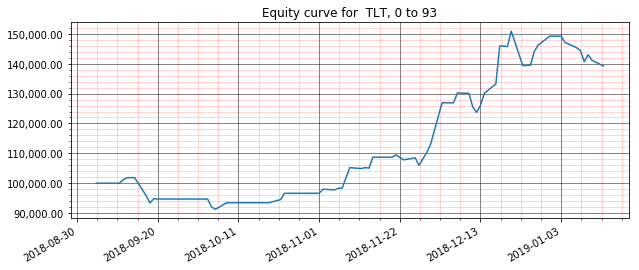

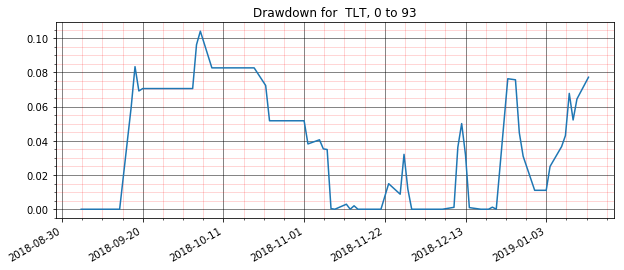

In [66]:
plot_tms = tms21.copy()
plot_tms = plot_tms.set_index(pd.DatetimeIndex(plot_tms['Date']))
plot_tms=plot_tms.drop('Date', axis=1)
plotTitle = "Equity curve for  " + issue + ", " + str(start) + " to " + str(end)
plotIt.plot_v1(plot_tms['equity'][:-2], plotTitle)
plotTitle = "Drawdown for  " + issue + ", " + str(start) + " to " + str(end)
plotIt.plot_v1(plot_tms['drawdown'][:-2], plotTitle)

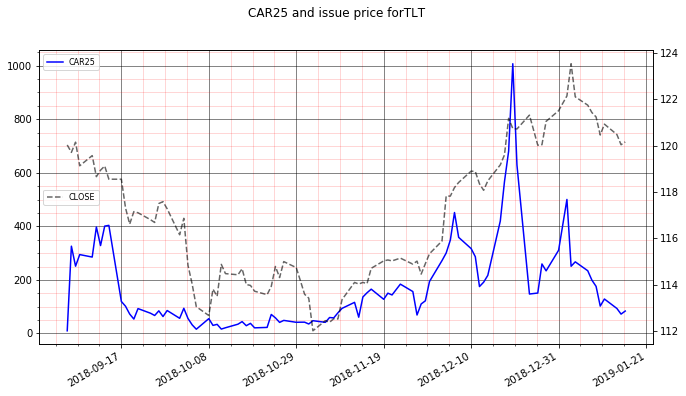

In [67]:
# Plot the equity stream
fig = plt.figure(figsize=(11,6))
fig.suptitle('CAR25 and issue price for' + issue)
ax1 = fig.add_subplot(111)
#ax1.plot(sst1.safef, color='green',label='safe-f')
ax1.plot(plot_tms.CAR25, color='blue',label='CAR25')
#ax1.plot(valData.equityValBeLongSignals, color='purple',label='ValBeLong')

ax1.legend(loc='upper left', frameon=True, fontsize=8)
ax1.label_outer()
ax1.tick_params(axis='x',which='major',bottom=True)
ax1.minorticks_on()
ax1.grid(True, which='major', color='k', linestyle='-', alpha=0.6)
ax1.grid(True, which='minor', color='r', linestyle='-', alpha=0.2)

#sst1['Pri']=valData.Pri
ax2 = ax1.twinx()
ax2.plot(plot_tms.Close, color='black',alpha=0.6,label='CLOSE',linestyle='--')
ax2.legend(loc='center left', frameon=True, fontsize=8)
ax2.label_outer()
fig.autofmt_xdate()